# Introduction to Entanglement

This part looks at some of the implications of quantum mechanics in 2D systems.  The concept of "entanglement" that you will meet here was one of the most contentious parts of early quantum physics–Einstein famously denounced its apparent "spooky action at a distance"–and now is one of the corenerstones of quantum computing.

## Initialisation code

**You need to run all cells in this section first for anything to work.**  Click "Runtime > Run all" in the top toolbar to automatically do this.  You don't need to read or understand the code in this section, but feel free to ask about it if you're interested.  [After running the cells, click here to jump to the exercises.](#start-here)

In [1]:
import keyword
import functools
import numbers

import numpy as np

%matplotlib inline
from matplotlib import pyplot
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120

import IPython
import ipywidgets

In [2]:
class Wavefunction:
    """
    A wavefunction for a particle-in-an-arbitrarily-dimensioned-box.  I assume
    that all the boxes dimensions are the same.
    """

    def __init__(self, dimensions, state_vector):
        if isinstance(dimensions, str):
            dimensions = (dimensions,)
        if not isinstance(dimensions, (list, tuple)):
            raise TypeError("'dimensions' must be a list of dimension names")
        if not dimensions:
            raise ValueError("can't have a 0D wavefunction")
        if not all(_valid_identifier(dimension) for dimension in dimensions):
            raise ValueError("all identifiers must have valid Python names")
        # Sort the dimensions so that objects created out-of-order still end up
        # looking the same.
        self.dimensions = sorted(dimensions)
        # I store each wavefunction as a vector, where each element is the
        # coefficient of a particular eigenstate of the system.  In real life
        # the phases can be complex, but to make the plotting clearer in this
        # notebook, I only use real coefficients.
        self.vector = np.asarray(state_vector, dtype=np.float64)
        if self.vector.ndim != len(self.dimensions):
            raise ValueError("state vector shape does not match dimensions")
        if 0 in self.vector.shape:
            raise ValueError("a dimension has 0 length")
        norm = np.linalg.norm(self.vector)
        # With floating-point numbers you can't reliably use '==' because
        # they're not 100% accurate, so you should compare within a tolerance.
        self.is_normalised = abs(norm - 1) < 1e-10

    def normalise(self):
        """Return a new Wavefunction which is normalised."""
        norm = np.linalg.norm(self.vector)
        if norm < 1e-10:
            # norm is effectively 0; just return the 0 vector.
            return Wavefunction(self.dimensions, np.zeros_like(self.vector))
        # Fix the gauge, so the first element's coefficient is positive.
        index = tuple(n[0] for n in np.nonzero(self.vector))
        vector = self.vector * (np.sign(self.vector[index]) / norm)
        return Wavefunction(self.dimensions.copy(), vector)

    def __add__(self, other):
        """
        Add this Wavefunction to another of the same dimension.  This magic
        method overloads the '+' operator.
        """
        if not isinstance(other, Wavefunction):
            return NotImplemented
        if self.dimensions != other.dimensions:
            raise ValueError("can't add wavefunctions of different dimensions")
        new_shape = tuple(
            np.max([self.vector.shape, other.vector.shape], axis=0)
        )
        new_vector = (
            _pad_to_size(new_shape, self.vector)
            + _pad_to_size(new_shape, other.vector)
        )
        return Wavefunction(self.dimensions, new_vector)

    def __sub__(self, other):
        """
        Subtract another Wavefunction of the same dimension from this one.
        This magic method overloads the binary '-' operator.
        """
        if not isinstance(other, Wavefunction):
            return NotImplemented
        return self + (-other)

    def __neg__(self):
        """
        Magic method that finds the negative of this object.  Overloads the
        unary '-' operator.
        """
        return -1*self

    def __mul__(self, other):
        """
        Multiply this object by something, with the other thing on the right.
        Defined for numbers and other wavefunctions that don't share a
        dimension with us.  This magic method overloads the '*' operator.
        """
        if isinstance(other, numbers.Real):
            # Multiplication by a scalar.  (Should be complex in real life, but
            # we're only considering real numbers for easier visualisation.)
            return Wavefunction(self.dimensions, other*self.vector)
        if not isinstance(other, Wavefunction):
            return NotImplemented
        # In the abstract linear algebra sense this operation is actually
        # called the "tensor product", not multiplication, but you'll see more
        # of that in third- and fourth-year quantum information.
        if set(self.dimensions) & set(other.dimensions):
            raise ValueError("can't multiply wavefunctions in the same dimension")
        # Because I let you create and combine vectors that aren't all in the
        # same "Hilbert space" from the beginning, I have to do a little bit of
        # convoluted logic here to make sure that the separate dimensions are
        # in the same order, no matter how you made this object.
        dimensions = self.dimensions + other.dimensions
        order = np.argsort(dimensions)
        vector = np.tensordot(self.vector, other.vector, axes=0).transpose(order)
        return Wavefunction(dimensions, vector)
    
    def __rmul__(self, other):
        """
        Multiply ourselves by something, which ourselves on the right.
        Normally in quantum mechanics, multiplication is not commutative, but
        with how I have defined things here, it's always safe to do so.
        """
        return self * other
    
    def __truediv__(self, other):
        """
        Divide this object by a real number.  Magic method overrides '/'.
        """
        if not isinstance(other, numbers.Real):
            return NotImplemented
        return self * (1 / other)

    def __call__(self, **dimensions):
        """
        Magic method that overloads the "function-call" syntax in Python.  You
        access this by doing `u(x=0, y=1)` on a `Wavefunction` `u`.

        This returns the value of the wavefunction evaluated at the given
        values for the dimensions.  If you pass a list or array to any of the
        dimensions, you get back a full mesh of values evaluated at every
        combination of the dimensions.
        """
        if set(dimensions) != set(self.dimensions):
            raise TypeError("must supply a value for each dimension")
        scalar = all(np.isscalar(x) for x in dimensions.values())
        dimensions = [
            np.atleast_1d(dimensions[dimension])
            for dimension in self.dimensions
        ]
        out = np.zeros(
            tuple(dimension.size for dimension in dimensions),
            dtype=np.float64,
        )
        wavenumber_scale = np.pi / BOX_WIDTH
        for ns in zip(*np.nonzero(self.vector)):
            ks = (np.array(ns) + 1) * wavenumber_scale
            # I recalculate the mesh each time because this minimises the
            # number of calls to the expensive `sin`, and `meshgrid` creates
            # very efficient arrays that don't copy as much data as you'd
            # expect.
            separate = np.meshgrid(*[
                np.sin(k*dim) for k, dim in zip(ks, dimensions)
            ], indexing='ij')
            out += self.vector[ns] * np.prod(separate, axis=0)
        # Apply the normalisation of the eigenstates.
        out *= np.sqrt(2 / BOX_WIDTH)**len(self.dimensions)
        return out.flat[0] if scalar else out
    
    def measure(self, **dimensions):
        """
        Find the new wavefunction if a measurement is performed with a 
        given result (e.g. `u.measure(x=0.4)`).
        """
        if set(dimensions) - set(self.dimensions):
            raise ValueError("unknown dimensions in measurement")
        if not (set(self.dimensions) - set(dimensions)):
            raise ValueError("measuring all dimensions fully localises the wavefunction")
        measure_i, keep_i = [], []
        for i, dimension in enumerate(self.dimensions):
            (measure_i if dimension in dimensions else keep_i).append(i)
        shape = tuple(self.vector.shape[i] for i in keep_i)
        vector = np.zeros(shape, dtype=np.float64)
        k_scale = np.pi / BOX_WIDTH
        for ns in zip(*np.nonzero(self.vector)):
            out_i = tuple(ns[i] for i in keep_i)
            sin_part = np.prod([
                np.sin((ns[i]+1)*k_scale*dimensions[self.dimensions[i]])
                for i in measure_i
            ])
            vector[out_i] += self.vector[ns] * sin_part
        return Wavefunction([self.dimensions[i] for i in keep_i], vector)

    def __repr__(self):
        """
        Magic method that is used to get the somewhat machine-readable
        representation of the object in a normal Python session.
        """
        return "".join([
            self.__class__.__name__, "(",
            repr(self.dimensions),
            ", ",
            repr(self.vector),
            ")"
        ])

    def _repr_latex_(self):
        """
        Magic method that Jupyter/IPython uses to get a LaTeX representation of
        the object.
        """
        parts = []
        for ns in zip(*np.nonzero(self.vector)):
            basis = "".join(
                rf"\lvert {{{n + 1}}}_{{{dimension}}}\rangle"
                for dimension, n in zip(self.dimensions, ns)
            )
            coeff = self.vector[ns]
            parts.append(f"{coeff:+.2f}{basis}")
        if not parts:
            return r"$$\text{[zero vector]}$$"
        if parts[0].startswith("+"):
            parts[0] = parts[0][1:]
        return r"$$" + " ".join(parts) + r"$$"
    
BOX_WIDTH = 1

def _pad_to_size(shape, array):
    """
    Helper function that adds zeros onto axes in an array to make it up to a
    certain shape.
    """
    pad_size = [(0, new - old) for new, old in zip(shape, array.shape)]
    return np.pad(array, pad_size)

def _valid_identifier(name):
    """
    Helper function to determine if a name is a valid Python identifier.
    """
    if not isinstance(name, str):
        return False
    if not name.isidentifier():
        return False
    return not keyword.iskeyword(name)

In [3]:
def x(n):
    """
    Get the nth eigenstate of the particle-in-a-box in the x-direction.  'n'
    must be a natural number.
    """
    if not isinstance(n, numbers.Integral):
        raise TypeError("'n' must be an integer")
    if n <= 0:
        raise ValueError("'n' must be a natural number")
    return Wavefunction(['x'], [0]*(n - 1) + [1])

def y(n):
    """
    Get the nth eigenstate of the particle-in-a-box in the y-direction.  'n'
    must be a natural number.
    """
    if not isinstance(n, numbers.Integral):
        raise TypeError("'n' must be an integer")
    if n <= 0:
        raise ValueError("'n' must be a natural number")
    return Wavefunction(['y'], [0]*(n - 1) + [1])

In [4]:
def plot_wavefunction(u):
    """Plot the given 1D or 2D wavefunction."""
    u = u.normalise()
    IPython.display.display(u)
    if len(u.dimensions) == 1:
        return _plot_wavefunction_1d(u)
    if len(u.dimensions) == 2:
        return _plot_wavefunction_2d(u)
    raise ValueError("can only plot 1D or 2D wavefunctions")
    
def plot_probability(u, _ylim=None):
    """
    Plot the probability density function of the given 1D or 2D
    wavefunction.
    """
    u = u.normalise()
    IPython.display.display(u)
    if len(u.dimensions) == 1:
        return _plot_probability_1d(u, ylim=_ylim)
    if len(u.dimensions) == 2:
        return _plot_probability_2d(u)
    raise ValueError("can only plot 1D or 2D wavefunctions")
    
def plot_probability_after_measurement(state):
    if len(state.dimensions) != 2:
        raise ValueError("can only plot for a 2D state")
    # Calculate the before-measurement bit first because it's always the same,
    # and as a side-effect we can calculate some limits that will _always_ fit
    # the entire plot in.
    state = state.normalise()
    points = [
        np.linspace(0, BOX_WIDTH, _choose_points(state, i))
        for i in range(len(state.dimensions))
    ]
    values = np.abs(state(**dict(zip(state.dimensions, points))))**2
    ylimits = np.min(values), np.max(values)
    before_measurement = np.trapz(values, points[0], axis=0)
    def interactive_bit(measurement_result):
        plot_probability(
            state.measure(**{state.dimensions[-1]: measurement_result}),
            _ylim=ylimits,
        )
        pyplot.plot(
            points[0], before_measurement,
            dashes=(10, 10),
        )
        pyplot.legend(['After measurement', 'Before measurement'])
    return interactive_bit
    
def _choose_points(u, dimension_index):
    peaks = np.max(
        np.nonzero(u.vector)[dimension_index],
        # Set a sensible minimum value.
        initial=2,
    )
    return 1 + 60*peaks

def _plot_wavefunction_1d(u):
    points = np.linspace(0, BOX_WIDTH, _choose_points(u, 0))
    values = u(**{u.dimensions[0]: points})
    pyplot.plot(points, values)
    pyplot.xlim((0, BOX_WIDTH))
    limits = (np.min(values), np.max(values))
    if limits[0] == limits[1]:
        limits = (-1, 1)
    pyplot.ylim(limits)
    pyplot.xlabel(u.dimensions[0])
    pyplot.ylabel("Wavefunction")
    pyplot.axhline(0, color='black', linewidth=0.7, dashes=(15, 15))
    
def _plot_wavefunction_2d(u):
    points = [
        np.linspace(0, BOX_WIDTH, _choose_points(u, i))
        for i in range(len(u.dimensions))
    ]
    values = u(**dict(zip(u.dimensions, points)))
    max_abs = np.max(np.abs(values))
    pyplot.pcolormesh(
        points[0], points[1], values.transpose(),
        # If you're colorblind and can't distinguish the positive region from
        # the negative, try changing the "PiYG" to one of
        #   "PRGn" (purple--green),
        #   "BrBG" (brown--blue/green),
        #   "PuOR" (purple--orange),
        #   "RdBu" (red--blue).
        cmap=matplotlib.cm.PiYG,
        vmin=-max_abs,
        vmax=max_abs,
        shading='auto',
    )
    pyplot.colorbar().set_label(
        "Wavefunction",
        rotation=90,
    )
    pyplot.xlim((0, BOX_WIDTH))
    pyplot.ylim((0, BOX_WIDTH))
    pyplot.xlabel(u.dimensions[0])
    pyplot.ylabel(u.dimensions[1])
    pyplot.gca().set_aspect('equal')
    
def _plot_probability_1d(u, ylim=None):
    points = np.linspace(0, BOX_WIDTH, _choose_points(u, 0))
    values = np.abs(u(**{u.dimensions[0]: points}))**2
    pyplot.plot(points, values)
    pyplot.xlim((0, BOX_WIDTH))
    limits = ylim if ylim is not None else (np.min(values), np.max(values))
    if limits[0] == limits[1]:
        limits = (-1, 1)
    pyplot.ylim(limits)
    pyplot.xlabel(u.dimensions[0])
    pyplot.ylabel("Probability density")
    
def _plot_probability_2d(u):
    points = [
        np.linspace(0, BOX_WIDTH, _choose_points(u, i))
        for i in range(len(u.dimensions))
    ]
    values = np.abs(u(**dict(zip(u.dimensions, points))))**2
    pyplot.pcolormesh(
        points[0], points[1], values.transpose(),
        cmap=matplotlib.cm.magma_r,
        shading='auto',
    )
    pyplot.colorbar().set_label(
        "Probability density",
        rotation=90,
    )
    pyplot.xlim((0, BOX_WIDTH))
    pyplot.ylim((0, BOX_WIDTH))
    pyplot.xlabel(u.dimensions[0])
    pyplot.ylabel(u.dimensions[1])
    pyplot.gca().set_aspect('equal')

<a name="start-here"></a>
## Introduction: How to use this notebook, and the 1D particle in a box

Remember the position wavefunctions of the eigenstates of the 1D particle in a box are
$$
\psi_n(x) = \sqrt{\frac2L} \sin(k_n x), \quad\text{where $k_n = n\pi/L$.}
$$

In this notebook, you can create a representation of the $x$-direction wavefunction $\psi_n(x)$ by calling the function `x(n)`.  You can multiply and divide these by real numbers (we're ignoring complex numbers to make plotting easier) and add together states to make superpositions, such as `(x(1) + 2*x(2)) / np.sqrt(5)`.  You can normalise a wavefunction `psi` by calling `psi.normalise()`.

In [5]:
(x(1) + 2*x(2)).normalise()

Wavefunction(['x'], array([0.4472136 , 0.89442719]))

You can plot the wavefunction by calling `plot_wavefunction(psi)`, or plot the probability density by calling `plot_probability(psi)`.  These functions will automatically normalise their inputs.

Wavefunction(['x'], array([0., 0., 1.]))

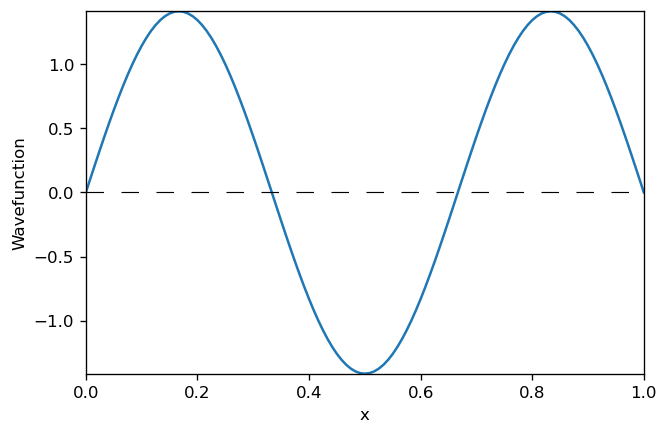

In [6]:
plot_wavefunction(x(3))

Wavefunction(['x'], array([ 0.        ,  0.70710678,  0.        , -0.70710678]))

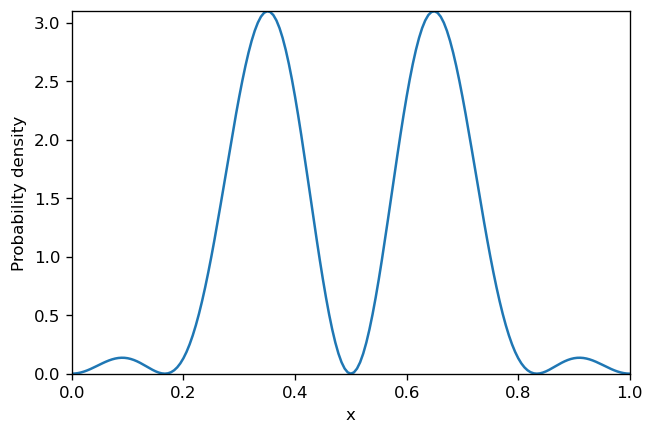

In [7]:
plot_probability(x(2) - x(4))

You can use the form `psi.measure(y=0.3)` to collapse a 2D wavefunction `psi` down to 1D based on the given measurement of position (_not_ of the energy).

In [8]:
state_2d = ((x(1) + x(2)) * (y(1) - y(2))).normalise()
state_2d

Wavefunction(['x', 'y'], array([[ 0.5, -0.5],
       [ 0.5, -0.5]]))

In [9]:
state_2d.measure(y=0.75).normalise()

Wavefunction(['x'], array([0.70710678, 0.70710678]))

## Questions: Investigating 2D wavefunctions

We are now considering a particle in a 2D box, where the widths of both dimensions are the same.  The $y$-position wavefunctions look exactly like the $x$-position ones in form.  In this notebook, you can make the state with wavefunction $\psi_{x,n}(x)\psi_{y,m}(y)$ by doing `x(n) * y(m)`.  You can combine these in the same manner as above, and plot them using the same functions.

### Part 1: simple 2D wavefunctions

Use the sliders below to plot some 2D wavefunctions $\lvert\psi\rangle=\lvert n_x\rangle\lvert n_y\rangle$ with varying $n_x$ and $n_y$.  
- What do you notice about the shapes of the graphs, for example symmetries?
- Where are you most likely to measure the particle in the $y$-direction?  Does that change if you measure its $x$-position first?

In [10]:
ipywidgets.interact(
    lambda n_x, n_y: plot_wavefunction(x(n_x) * y(n_y)),
    n_x=ipywidgets.IntSlider(value=1, min=1, max=5),
    n_y=ipywidgets.IntSlider(value=1, min=1, max=5),
);

interactive(children=(IntSlider(value=1, description='n_x', max=5, min=1), IntSlider(value=1, description='n_y…

### Part 2: "separable" states (finish by 09:20/11:20)

So far, the wavefunctions we have plotted could be written in the form
$$
\Psi(x, y) = \psi_x(x)\psi_y(y),
$$
where you can separate out the $x$ and $y$ components.

The code starts out with the state
$$\lvert\psi\rangle = \frac12\Bigl(\lvert 1_x\rangle\lvert 1_y\rangle - \lvert 1_x\rangle\lvert 2_y\rangle - \lvert 2_x\rangle\lvert 1_y\rangle + \lvert 2_x\rangle\lvert 2_y\rangle\Bigr).$$
This is actually separable, because you could also write it as
$$\lvert\psi\rangle = \frac12\bigl(\lvert 1_x\rangle - \lvert 2_x\rangle\bigr)\bigl(\lvert 1_y\rangle - \lvert 2_y\rangle\bigr).$$

- In writing, can you come up with a quantum state which _cannot_ be written in this separated form?
- Use the code cell below to plot such a state and see what the wavefunction looks like.  Compare its shape to the plots you made in the previous part.

Wavefunction(['x', 'y'], array([[ 0.5, -0.5],
       [-0.5,  0.5]]))

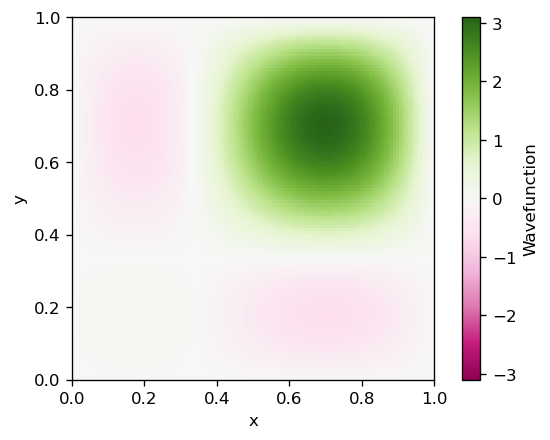

In [11]:
# Change the next line to represent your non-separable state.  The state
# will be normalised automatically for you when it is plotted.
state = x(1)*y(1) - x(2)*y(1) - x(1)*y(2) + x(2)*y(2)
plot_wavefunction(state)

### Part 3: non-separable states (finish by 09:45/11:45)

Consider a particle trapped in a 2D infinite square well in a state

$$
\lvert\theta\rangle =
    \sin(\theta)\lvert 1_x\rangle \lvert 2_y\rangle
    + \cos(\theta)\lvert 2_x\rangle\lvert 1_y\rangle.
$$

The plot below is the probability distribution over $x$ and $y$.  Use the slider to change the angle $\theta$ as a fraction of $\pi$.

- When is this state separable and when is it not?
- On paper, what would the instantaneous wavefunction look like we meausred $y = \frac12$?  What about if we measured $y=\frac14$?
- Does the probability distribution of $x$ measurements depend on what you measure $y$ to be?  What does this imply physically?

In [12]:
ipywidgets.interact(
    lambda angle: plot_probability(
        np.sin(np.pi*angle)*x(1)*y(2) + np.cos(np.pi*angle)*x(2)*y(1)
    ),
    angle=ipywidgets.FloatSlider(min=0, max=1, step=0.05, continuous_update=False),
);

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='angle', max=1.0, step=0.05)…

The following cell compares the probability density of the $x$-position of the state $\lvert\pi/4\rangle$ before and after a measurement of $y$ (you can also change it to use a separable state to see the difference).

- Check that a measurement in one dimension affects the probability distribution in the other for the non-separable state.
- Check that the same measurement on a separable state doesn't affect the other probability distribution.

In [13]:
nonseparable = (x(1)*y(2) + x(2)*y(1)) / np.sqrt(2)
separable = (x(1) - x(2)) * (y(1) - y(2)) / 2

ipywidgets.interactive(
    lambda plotter, measurement_result: plotter(measurement_result),
    plotter=ipywidgets.Dropdown(
        options=[
            ('non-separable', plot_probability_after_measurement(nonseparable)),
            ('separable', plot_probability_after_measurement(separable)),
        ],
        description='State type',
    ),
    measurement_result=ipywidgets.FloatSlider(
        value=BOX_WIDTH/2,
        min=0, max=BOX_WIDTH, step=BOX_WIDTH/20, 
        description="y_0",
        continuous_update=False,
    ),
)

interactive(children=(Dropdown(description='State type', options=(('non-separable', <function plot_probability…

### Part 4: two entangled particles in boxes

Now consider this system with two identical particles each in the ground state of a 1D infinite square well $\lvert 1_u\rangle\lvert 1_d\rangle$ ($u$ for "up" and $d$ for "down"). There is a photon source connected to the wells by fibre via a beam splitter, such that a horizontally polarised photon ($\lvert H\rangle$) goes to the bottom well, and vertically polarised photon ($\lvert V\rangle$) goes to the top.

![](https://raw.githubusercontent.com/jakelishman/2020-imperial-yr2-seminars/main/entanglement_circuit.svg)

A horizontally polarised photon reaching the bottom well will excite the particle from $\lvert 1_d\rangle$ to $\lvert 2_d\rangle$, and similar for a vertically polarised photon in the top well.

One photon in a polarisation state $\bigl(\sin\theta\lvert H\rangle + \cos\theta\lvert V\rangle\bigr)$ is sent through the fibre.

- What is the state of the two wells system after the photon has been absorbed?
- Can you write down separate wavefunctions for each particle individually?  What happens to the top particle if you measure the bottom one?